In [70]:
import os
import glob
import numpy as np
import pandas as pd

import openslide
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt 

from utils import * 

### WSI, foreground tissue mask 

In [2]:
wsi_pt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSIs/KHP_RM/17064108_FPE_1.ndpi'
mask_pt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/WSI_QC/KHP_RM/17064108_FPE_1.ndpi/17064108_FPE_1.ndpi_mask_use.png'

579


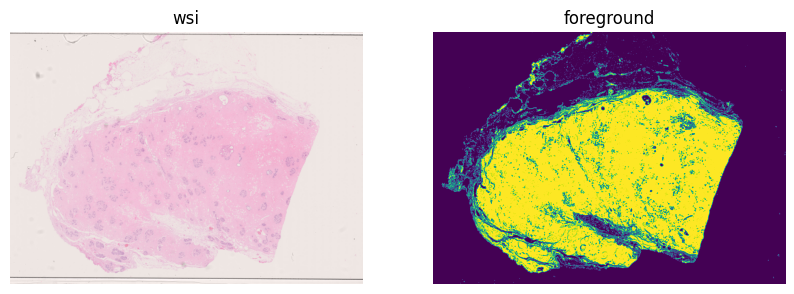

In [3]:
wsi = openslide.OpenSlide(wsi_pt)
im_wsi = wsi.read_region((0,0), wsi.level_count-1, wsi.level_dimensions[wsi.level_count-1]).convert('RGB')
im_mask = Image.open(mask_pt)
plot_oneline([im_wsi, im_mask], ['wsi', 'foreground'], (10,10))

### Tissue Classification by 512px-based Tissue-Classifier

In [ ]:
weights = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/ckpts/Tissue_Classifier.h5'
TC = get_TC(weights)
save_folder = "/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/"

In [12]:
tissue_map = run_TC_one_slide(wsi, mask_pt, TC, save_folder, patch_size=128, foreground_thes=0.7)

/tmp/ipykernel_391280/3858112497.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  tc_predictions = TC.predict_generator(generator=wsi_sequence, steps=len(wsi_sequence),verbose=1)


2345/2345 [==============================] - 32s 14ms/step


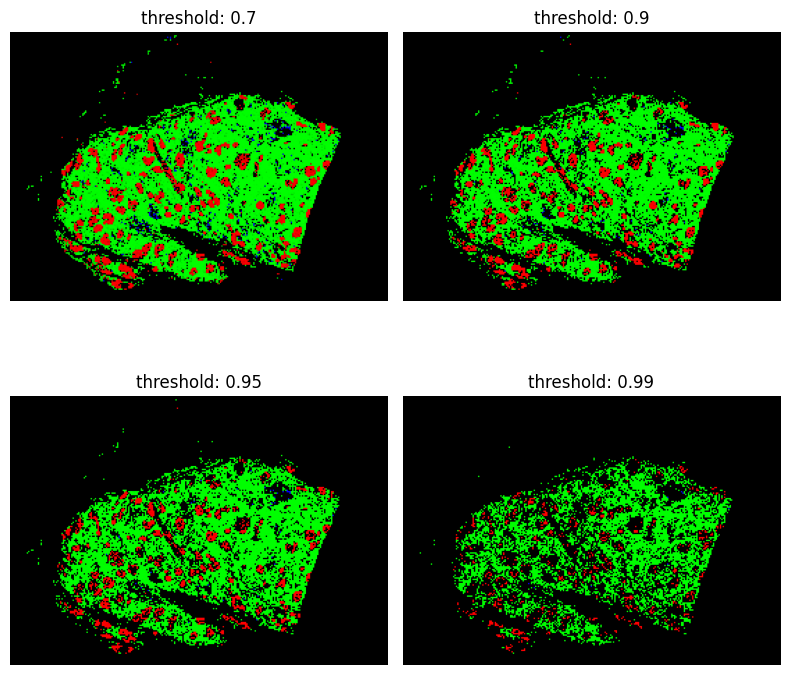

In [14]:
images = []
thresholds = [0.7, 0.9, 0.95, 0.99]
for threshold in thresholds:
    im = tissue_map.copy()
    im[:,:, 0][tissue_map[:,:, 0] < threshold] = 0
    im[:,:, 1][tissue_map[:,:, 1] < threshold] = 0
    im[:,:, 2][tissue_map[:,:, 2] < threshold] = 0
    images.append(im)


fig, axs = plt.subplots(2, 2, figsize=(8, 8))
counter = 0
for x in range(2):
    for y in range(2):
        axs[x, y].imshow(images[counter])
        axs[x, y].set_title(f'threshold: {thresholds[counter]}')
        axs[x, y].axis('off') 
        counter += 1
plt.tight_layout()
plt.show()

### export JSON file of pseudo tissue class annotations

In [18]:
cls_dict = {'epithelium': 0, 'stroma':1, 'adipocytes':2, 'background': 3}
json_pt = f"{save_folder}17064108_FPE_1_TC512.json"

In [19]:
TC_cls = tissue_map.copy()
TC_cls = np.argmax(TC_cls, axis=2)
TC_cls[tissue_map[:,:,0]==0] = 3

patch_size, _ = parse_patch_size(wsi, patch_size=128)
print(patch_size)

cls_df = {'orig_x': [], 'orig_y': [], 'cls': []}
for x in range(TC_cls.shape[1]):
    for y in range(TC_cls.shape[0]):
        cls_df['orig_x'].append(int(x * patch_size))
        cls_df['orig_y'].append(int(y * patch_size))
        cls_df['cls'].append(TC_cls[y, x])
cls_df = pd.DataFrame.from_dict(cls_df)
cls_df = cls_df.loc[cls_df['cls']!=3, ]

get_JSON(cls_df, cls_dict, json_pt, patch_size, require_bounds=False)

579
/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/17064108_FPE_1_TC512.json saved!


## Lobule binary mask

In [32]:
level = 4
small_objects=400000
threshold = 0.7
TC_maskpt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17064108_FPE_1/17064108_FPE_1_TCprobmask.npy'

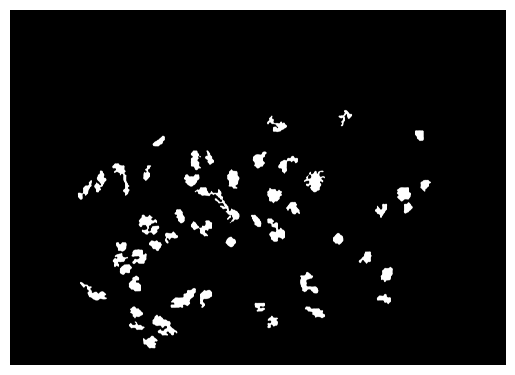

In [33]:
wsi_mask_ratio = wsi.level_downsamples[level]
small_objects = small_objects / wsi_mask_ratio
epi_mask = process_TCmask(wsi_pt, TC_maskpt, level, threshold, small_objects)
plt.imshow(epi_mask, cmap = 'gray')
plt.axis("off")

im = Image.fromarray(epi_mask * 255)
im.save(f"{save_folder}17064108_FPE_1.ndpi_TC_({wsi.level_downsamples[level]},0,0,{epi_mask.shape[1]},{epi_mask.shape[0]})-mask.png")


## ROI detection 

In [34]:
roi_width=250
bbx_pt = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17064108_FPE_1/17064108_FPE_1_bbx.png'

(-0.5, 9855.5, 7055.5, -0.5)

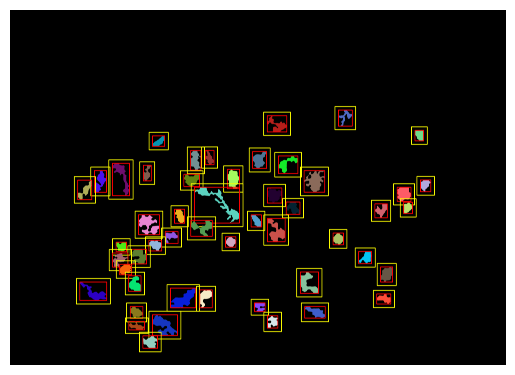

In [35]:
mpp = float(wsi.properties['openslide.mpp-x'])
roi_width = int(roi_width / float(mpp) / wsi_mask_ratio) 
bbx_map = bbx_overlay(epi_mask, bbx_pt, roi_width) 
plt.imshow(bbx_map)
plt.axis('off')

In [ ]:
## Single ROI

In [36]:
wsi_id = "17064108_FPE_1"

There're 50 ROIs detected


(-0.5, 6095.5, 5551.5, -0.5)

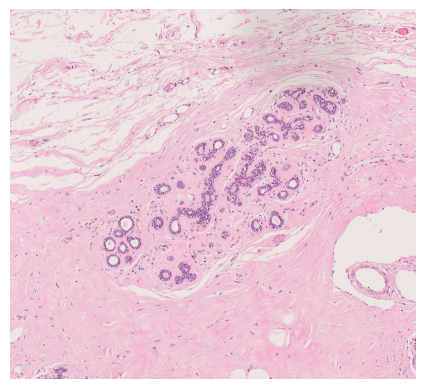

In [38]:
# get roi ids for all ROIs detected on the WSI
roi_ids = get_roi_ids(epi_mask, wsi_id, roi_width, wsi_mask_ratio)
im = show_roi(wsi, roi_ids[3])
plt.imshow(im)
plt.axis('off')

In [ ]:
## JSON file of pseudo tissue class annotations within ROIs

In [39]:
json_pt = f"/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17064108_FPE_1/17064108_FPE_1_TC512_ROIdetection.json"

In [63]:
patch_df = save_patchcsv(roi_ids, patch_size, TC_maskpt, output_dir=None)
patch_df = addWSIxy(patch_df)
get_JSON(patch_df, cls_dict, json_pt, patch_size, require_bounds=False)

/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/RootDir/KHP_RM/17064108_FPE_1/17064108_FPE_1_TC512_ROIdetection.json saved!


## Sample patches

In [66]:
num2sample = 1500

3000


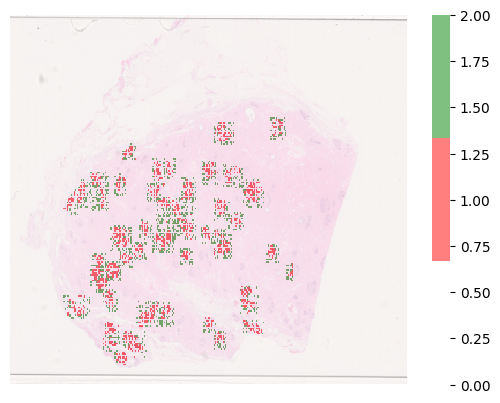

In [88]:
df = patch_df.copy()
counter = 0
for cls in ["epithelium", "stroma"]:
    df_cls = df.loc[df["cls"] == cls,]
    df_cls = df_cls.sample(frac=1)
    df_cls = df_cls.iloc[:num2sample, :]
    if counter == 0:
        patch_sampled = df_cls
    else:
        patch_sampled = pd.concat([patch_sampled, df_cls])
    counter += 1
print(len(patch_sampled))

fig = overlay_patch_sampled(patch_sampled, wsi_pt, patch_size, save_folder)

### CAM

[0.95 0.05 0.  ]
(16, 16)
(512, 512, 3)


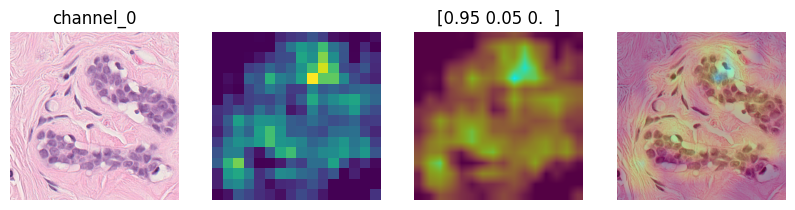

In [48]:
channel = 0
pred_prob, CAM, cam_heatmap, super_imposed_cam = get_GAPCAM(img_path = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/patch.png', 
                                                            model = TC, layer='conv_pw_13_relu', label_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',pred_prob,''], figure_size=(10, 5))

[0.02 0.98 0.  ]
(16, 16)
(512, 512, 3)


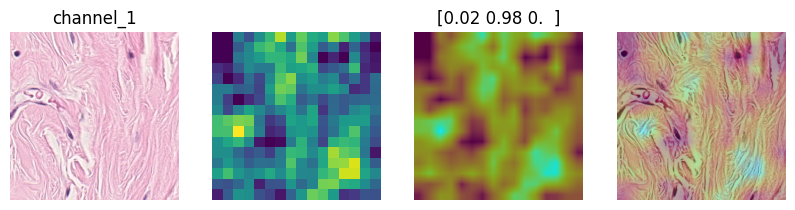

In [55]:
channel = 1
pred_prob, CAM, cam_heatmap, super_imposed_cam = get_GAPCAM(img_path = '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/patch1.png', 
                                                            model = TC, layer='conv_pw_13_relu', label_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',pred_prob,''], figure_size=(10, 5))

[0.   0.02 0.98]
(16, 16)
(512, 512, 3)


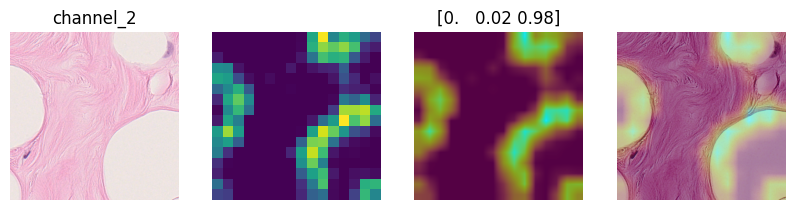

In [60]:
channel = 2
pred_prob, CAM, cam_heatmap, super_imposed_cam = get_GAPCAM(img_path= '/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/patch2.png', 
                                                            model = TC, layer='conv_pw_13_relu', label_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',pred_prob,''], figure_size=(10, 5))

### grad-CAM

tf.Tensor([[9.0260327e-01 9.6731335e-02 6.6542206e-04]], shape=(1, 3), dtype=float32)
(512, 512, 3)


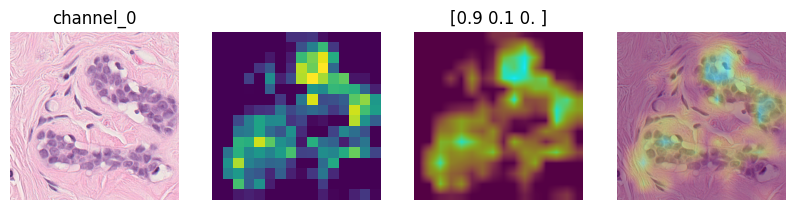

In [77]:
channel = 0
preds, CAM, cam_heatmap, super_imposed_cam = get_gradCAM(img_path='/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/patch.png',
                                                         model=TC, last_conv_layer_name='conv_pw_13_relu', pred_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','', preds[0], ''], figure_size=(10, 5))

tf.Tensor([[2.6003942e-02 9.7303128e-01 9.6477242e-04]], shape=(1, 3), dtype=float32)
(512, 512, 3)


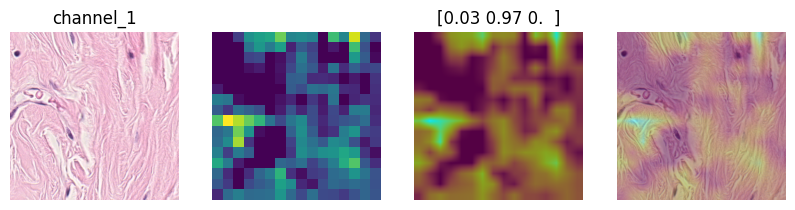

In [80]:
channel = 1
preds, CAM, cam_heatmap, super_imposed_cam = get_gradCAM(img_path='/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/patch1.png',
                                                         model=TC, last_conv_layer_name='conv_pw_13_relu', pred_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',preds[0], ''], figure_size=(10, 5))

tf.Tensor([[2.6386080e-05 7.5047935e-04 9.9922311e-01]], shape=(1, 3), dtype=float32)
(512, 512, 3)


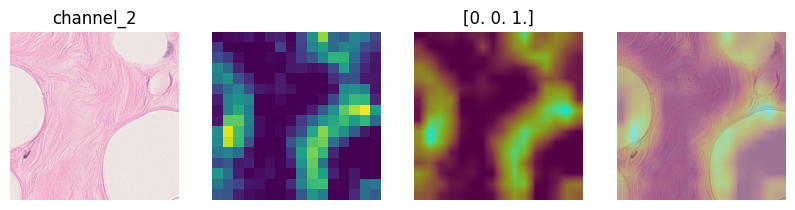

In [84]:
channel = 2
preds, CAM, cam_heatmap, super_imposed_cam = get_gradCAM(img_path='/scratch/prj/cb_normalbreast/Siyuan/prj_normal/BreastAgeNet/temp/patch2.png',
                                                         model=TC, last_conv_layer_name='conv_pw_13_relu', pred_index=channel)
plot_oneline(img_list=[img, CAM, cam_heatmap, super_imposed_cam], caption_list=[f'channel_{channel}','',preds[0], ''], figure_size=(10, 5))

### Alternatively, using TC_1024

In [36]:
TC_1024 = get_TC1024()
TC_1024.summary()

/scratch/users/k21066795/conda/tfgpu_env/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024, 1024, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, 512, 512, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 512, 512, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 512, 512, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 512, 512, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 512, 512, 32)      128 

(-0.5, 135.5, 96.5, -0.5)

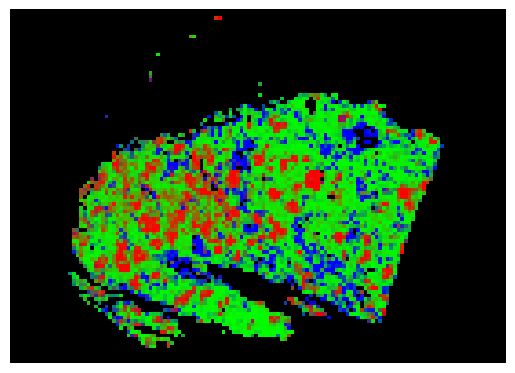

In [40]:
tissue_map1024 = run_TC_one_slide(wsi, mask_pt, TC_1024, outputDir, patch_size=256, foreground_thes=0.7)            
plt.imshow(tissue_map1024)
plt.axis('off')